In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from printTable import printTable # helper function

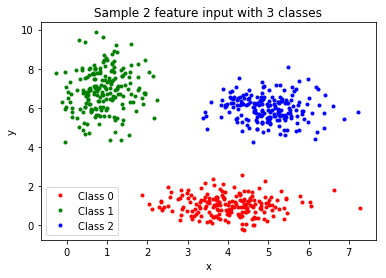

In [3]:
colors = ['r', 'g', 'b']

# Define three cluster centers
centers = [[4, 1],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.5],
          [0.5, 1.1],
          [0.7, 0.7]]

# seeded for reproducibility
np.random.seed(2)  

# Initial varables
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)

# Zip object is an iterator of tuples, enumerate returns centers: sigmas pair
# Total of 200 sample points, in 3 clusters
for i, ((x_center, y_center), (x_sigma, y_sigma)) in enumerate(zip(centers, sigmas)):
    # Create row array x or y value of each point
    xpts = np.hstack((xpts, np.random.standard_normal(200) * x_sigma + x_center))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * y_sigma + y_center))
    labels = np.hstack((labels, np.ones(200) * i))


# Remove the extra 0 at front 
xpts = np.delete(xpts,0)
ypts = np.delete(ypts,0)
labels = np.delete(labels,0)

# Visualize the test data
for j in range(3):
    plt.plot(xpts[j == labels],ypts[j==labels],'.', color = colors[j], label = 'Class %s'%j)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sample 2 feature input with 3 classes')
plt.legend(loc='lower left')
plt.show()
xy = np.vstack((xpts,ypts))

In [4]:
def svm_contour(x, w , c):
    # c = 0 for decision boundry, +1, -1 for support
    # x*w[0] +  unknown * w[1] + 1*w[2] = c
    x_plot = (c-x*w[0]-w[2])/w[1]
    return x_plot

After 4666 itrations, reached bottom of valley


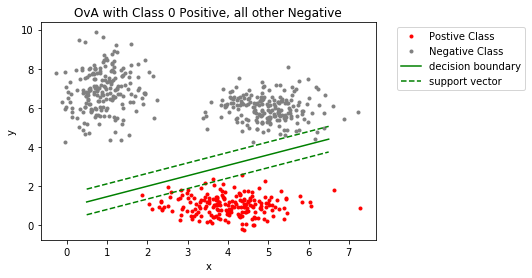

After 621 itrations, reached bottom of valley


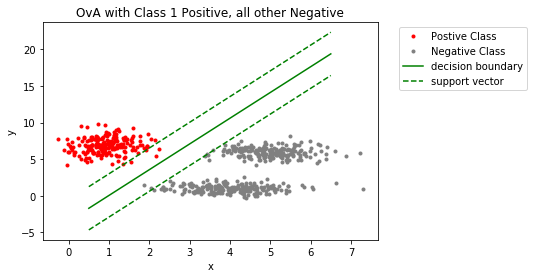

After 3488 itrations, reached bottom of valley


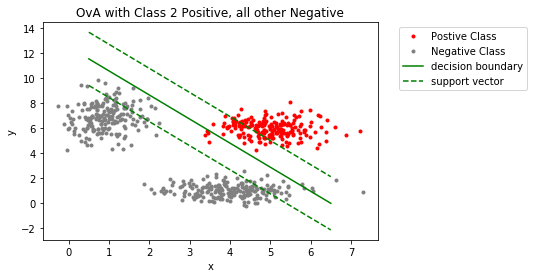

In [5]:
# Prep simple data in format two columns = two features = two axis
X = xy.transpose()
b = labels.transpose()

# model parameters
num_samples = len(b)
X_svm = np.hstack((X, np.ones((num_samples, 1))))
num_features = len(X[0])
w_k = np.zeros((num_features+1, 1))

r = 0.1 # regularizer (aka lambda)
U, s, V = np.linalg.svd(X_svm)
tau = 1/s[0]**2 # max stepsize
#print("Step size tau: {:0.10f}".format(tau))

# loop through each class
classes = [0,1,2]
b_classes = np.zeros((len(b),len(classes)))
b_test_svm = np.zeros(b_classes.shape)
w_svm = np.zeros((len(w_k),len(classes)))
descent_done = False
for c in classes:
    
    # form binary labels, assign +1 to one class, -1 to all others
    b_svm = np.where(b == c, 1, -1)
    b_classes[:,c] = b_svm.reshape(len(b_svm))
    last_loss = 100000000000000.
    descent_done = False
    # train svm
    num_steps = 50000
    iterations= 0
        
    counter = 0
    counter2 = 0

    while not descent_done:
        loss = 0
        # loop through training samples
        l_hinge = np.zeros(w_k.shape)
        for s in range(num_samples):
            # indicator function
            counter2 +=1
            if b_svm[s]*X_svm[s]@w_k < 1:
                counter +=1
                loss += (1-b_svm[s]*X_svm[s]@w_k)
                l_hinge = np.add(l_hinge, -b_svm[s]*X_svm[s].reshape(l_hinge.shape))

        # comapre loss to determine if reached minimum
        if(last_loss < loss):
            print("After %d itrations, reached bottom of valley" %iterations)
            #print(w_k)
            descent_done = True
        #update for next iteration
        w_k = w_k - tau*(l_hinge+2*r*w_k)
        last_loss = loss
        iterations +=1
      
    # save weights
    w_svm[:,c] = w_k.reshape(len(w_k)) # svm
    
    # 2D Graph of seperated data
    fig = plt.figure()
    plt.plot(X[(c==b),0],X[(c==b),1],'.', color = 'r', label = 'Postive Class')
    plt.plot(X[(c!=b),0],X[(c!=b),1],'.', color = 'grey', label = 'Negative Class')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('OvA with Class %s Positive, all other Negative'%c)
    
    # SVM bounds plot
    plot_bounds = [0.5, 6.5]
    db = [svm_contour(plot_bounds[0], w_k, 0), svm_contour(plot_bounds[1], w_k, 0)] 
    db_pos1 = [svm_contour(plot_bounds[0], w_k, 1.), svm_contour(plot_bounds[1], w_k, 1.)] 
    db_neg1 = [svm_contour(plot_bounds[0], w_k, -1.), svm_contour(plot_bounds[1], w_k, -1.)] 
    plt.plot(plot_bounds,db, color="green", label="decision boundary")
    plt.plot(plot_bounds,db_pos1, color="green", linestyle="--", label="support vector")
    plt.plot(plot_bounds,db_neg1, color="green", linestyle="--")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
    #plt.tight_layout()
    plt.show()

In [6]:
# Test svm against known training data
header = ["class", "  svm  "]
data = []
for c in classes:
    b_hat_svm = X_svm@w_svm[:,c]
    b_test_svm[:,c] = b_hat_svm.reshape(len(b))

    # find percent incorrect
    num_incorrect_svm = np.sum(np.sign(b_test_svm[:,c]) != b_classes[:,c])
    percent_incorrect_svm = num_incorrect_svm/len(b)*100
    data.append([c,"{:0.2f} %".format(percent_incorrect_svm)])
    
printTable(header,data)

| class |   svm   | 
| ----- | ------- | 
|   0   |  0.00 % | 
|   1   |  0.00 % | 
|   2   |  1.50 % | 


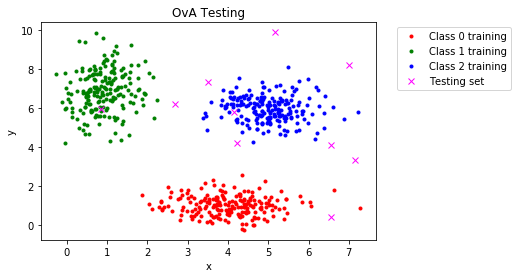

The Class with highest probability after applying to the three binary classifiers wins
Class 0 probability: 0.3
Class 1 probability: 0.2
Class 2 probability: 0.7
This testing set predected as class 2


In [7]:
# seeded random ensures reproducibility
np.random.seed(6)
# randomly generate 10 points for testing purpose
sampleNum = 10
X_testing = np.random.rand(sampleNum,2)
X_testing = np.multiply(X_testing, [8,10])
X_testing = np.hstack((X_testing, np.ones((sampleNum, 1))))
Y_testing = np.ndarray((3,1))
count_per_class = np.ndarray((num_samples,3))
for j in range(3):
    plt.plot(xpts[j == labels],ypts[j==labels],'.', color = colors[j], label = 'Class %s training'%j)

plt.xlabel('x')
plt.ylabel('y')
plt.title('OvA Testing')
plt.plot(X_testing[:,0],X_testing[:,1],'x', color = 'fuchsia', label = 'Testing set')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.show()
print("The Class with highest probability after applying to the three binary classifiers wins")
for c in classes:
    count = np.sum(X_testing@w_svm[:,c] > 0)
    print("Class {} probability: {}".format(c, count/sampleNum) )
    Y_testing[c] = count

print("This testing set predected as class %d"%np.argmax(Y_testing))


step size tau: 0.0000443218
after 4128 itrations, reached bottom of valley
[[ 3.13763607]
 [-0.53655282]
 [-4.85086079]]


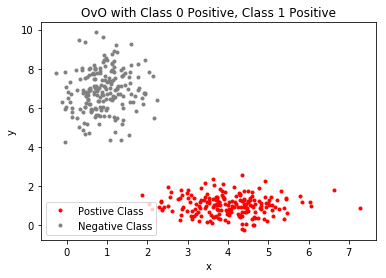

step size tau: 0.0000443218
after 9418 itrations, reached bottom of valley
[[ 3.10140545]
 [-3.93264475]
 [-1.18977999]]


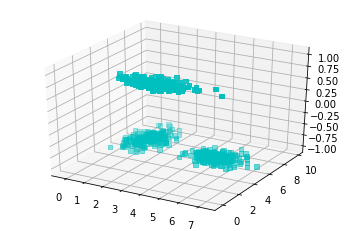

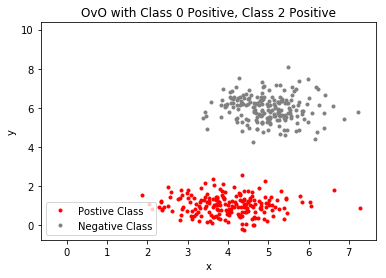

step size tau: 0.0000443218
after 2178 itrations, reached bottom of valley
[[-1.36956223]
 [ 0.71365658]
 [-0.50625477]]


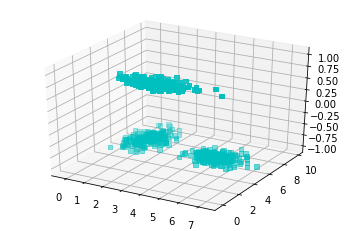

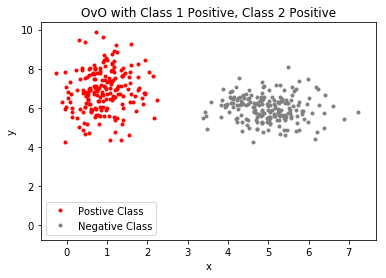

| class |   svm   | 
| ----- | ------- | 
|  OvO  |  0.50 % | 


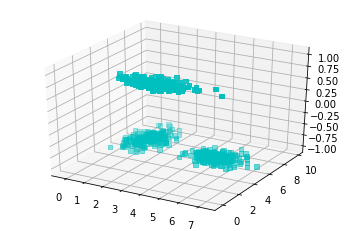

In [8]:
red = np.where(b == 0)
green = np.where(b == 1)
blue = np.where(b == 2)
    
weights_classes = []
#print(red[0])
#print(green[0])
#print(blue[0])
descent_done = False

for i in range(len(classes)):
    for j in range(len(classes)):
        if j>i:
            #create test groups
            g1 = np.where(b == i)[0]
            g2 = np.where(b == j)[0]

            X_class1 = [X_svm[k] for k in g1]
            X_class2 = [X_svm[k] for k in g2]
            X_class = np.vstack((X_class1,X_class2))
            b_class_orig1 = [b[k] for k in g1]
            b_class_orig2 = [b[k] for k in g2]
            b_class_orig = b_class_orig1 + b_class_orig2
            b_svm = np.where(np.asarray(b_class_orig) == i, 1, -1)

            # train svm
            last_loss = 100000000000000.
            descent_done = False
            # train svm
            num_steps = 50000
            iterations= 0
            counter = 0
            counter2 = 0
            while not descent_done:
                loss = 0
                # loop through training samples
                l_hinge = np.zeros(w_k.shape)
                for s in range(len(b_svm)):
                    # indicator function
                    counter2 +=1
                    if b_svm[s]*X_class[s]@w_k <= 1:
                        counter +=1
                        loss += (1-b_svm[s]*X_class[s]@w_k)
                        l_hinge = np.add(l_hinge, -b_svm[s]*X_class[s].reshape(l_hinge.shape))
                # comapre loss to determine if reached minimum
                #print(last_loss,loss)
                if(last_loss < loss):
                    print("step size tau: {:0.10f}".format(tau))
                    print("after %d itrations, reached bottom of valley" %iterations)
                    print(w_k)
                    descent_done = True
                w_k = w_k - tau*(l_hinge+2*r*w_k)
                last_loss = loss
                iterations +=1

            # save weights
            weights_classes.append(w_k.reshape(len(w_k))) # svm
            
            # Graph
            fig = plt.figure()
            plt.plot(X[(i!=b),0],X[(i!=b),1],'.', color = 'w')
            plt.plot(X[(i==b),0],X[(i==b),1],'.', color = 'r', label = 'Postive Class')
            plt.plot(X[(j==b),0],X[(j==b),1],'.', color = 'grey', label = 'Negative Class')
            
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('OvO with Class %s Positive, Class %d Positive'%(i,j))
            plt.legend(loc='lower left')
            plt.show()
            
            # Add svm plot
            #space = 2
            #db_range = np.linspace(db,db,num=space)
            #db_range_pos1 = np.linspace(db_pos1,db_pos1)
            #db_range_neg1 = np.linspace(db_neg1,db_neg1,num=space)
            x_range = np.linspace(0,8,num =50)
            y_range = np.linspace(0,10,num =50)
            const_range = np.ones(50)
            plot_range =  np.transpose(np.vstack((np.vstack((x_range,y_range)), const_range)))

            #
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            hehe = np.append(np.ones(200),-np.ones(400))
            ax.scatter(X[:,0],X[:,1],hehe, c='c', marker='s')
            plt.show
            
#print(weights_classes)

# test svm against known training data
header = ["class", "  svm  "]
data = []
count_class = np.zeros((3))
b_test_svm = []

c1 = 0
c2 = 1
num_wrong = 0
for x in X_svm: 
    count_class = [0,0,0]
    for w in range(len(weights_classes)):
        b_hat_svm = x@weights_classes[w]
        #print(c1,c2)
        #print(b_hat_svm)
        if b_hat_svm > 0:
            count_class[c1] = count_class[c1] + 1
        elif b_hat_svm < 0:
            count_class[c2] = count_class[c2] + 1
        if c2<len(classes) - 1:
            c2 = c2 + 1
        else:
            c1 = c1 + 1
            c2 = c1 + 1
    
    
#print(count_class)
    c1 = 0
    c2 = 1
    b_test_svm.append(classes[np.argmax(count_class)])
#print(b_test_svm)
#print(b_classes)

for m in range(len(b_test_svm)):
    if np.sign(b_classes[m][b_test_svm[m]]) == -1:
        num_wrong = num_wrong+1
# find percent incorrect
#num_incorrect_svm = np.sum(np.sign(b_test_svm[:,w]) != b_classes[:,w])
percent_incorrect_svm = num_wrong/len(b)*100

data.append(["OvO","{:0.2f} %".format(percent_incorrect_svm)])

printTable(header,data)